# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
%%bash
rm dataset/scores/tf_vae_only_nsl_kdd_all.pkl

rm: cannot remove 'dataset/tf_vae_only_nsl_kdd_all.pkl': No such file or directory


In [3]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [4]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [5]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [6]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    x_test_ = np.hstack((x_test_, np.random.normal(size = (x_test_.shape[0], y_train.shape[1]))))

    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.99186991653217405

In [7]:
import tensorflow as tf


In [8]:
class network(object):
    
    input_dim = 124
    classes = 2
    hidden_encoder_dim = 124
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 124
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)
            
            loss = tf.clip_by_value(loss, -1e-4, 1e-4)
            loss = tf.where(tf.is_nan(loss), 1e-4, loss)
            loss = tf.where(tf.equal(loss, -1e-4), tf.random_normal(loss.shape), loss)
            loss = tf.where(tf.equal(loss, 1e-4), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            
            correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate= self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [9]:
import collections
import time
import sklearn.metrics as me 


class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'f1_score', 'test_score_20', 'f1_score_20', 'time_taken'])

    predictions = {}
    predictions_ = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h, f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    #print("Step {} | Training Loss:".format(epoch), end = " " )
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                      net.regularized_loss, 
                                                      ], #net.summary_op
                                                      feed_dict={net.x: x_train[i,:], 
                                                                 net.y_: y_train[i,:], 
                                                                 net.keep_prob:1, net.lr:lr})

                        train_batch()

                        count = 10
                        if((train_loss > 1e9 or np.isnan(train_loss) ) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()
                            count -= 1

                        #summary_writer_train.add_summary(summary_str, epoch)
                        #if(train_loss > 1e9):

                        #print("{:.6f}".format(train_loss), end = ", " )

                    #print("")
                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})


                    accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    f1_score = me.f1_score(actual_value, pred_value)
                    accuracy_, test_loss_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                                           net.pred, 
                                                                                           net.actual, net.y], 
                                                                                          feed_dict={net.x: preprocess.x_test_, 
                                                                                                     net.y_: preprocess.y_test_, 
                                                                                                     net.keep_prob:1, net.lr:lr})
                    f1_score_ = me.f1_score(actual_value_, pred_value_)
                    #print("*************** \n")
                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                    print("Accuracy on Test data: {}, {}".format(accuracy, accuracy_))
                    #print("*************** \n")
                    #print("Accuracy on Test data: {}".format(accuracy))


                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                        Train.best_acc = accuracy
                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}/model"
                                       .format(epochs,h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual":actual_value})
                        curr_pred_ = pd.DataFrame({"Attack_prob":y_pred_[:,-2], "Normal_prob":y_pred_[:, -1], "Prediction":pred_value_, "Actual": actual_value_})
                        
                        Train.predictions.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})
                        Train.predictions_.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred_, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})

            

In [10]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]



    def start_training():

        global df_results
        global past_scores
        
        Train.predictions = {}
        Train.predictions_ = {}

        Train.results = []
        
        features_arr = [1, 12, 24, 48, 122]
        hidden_layers_arr = [1, 3]

        epochs = [15]
        lrs = [1e-2, 1e-2, 1e-3]

        print("********************************** Entering Loop ******************************")

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict1_ = {}
        dict2 = []

        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)

        for k, (v1_, v2) in Train.predictions_.items():
            dict1_.update({k: v1_})

        Train.predictions = dict1
        Train.predictions_ = dict1_
        
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)

        if not os.path.isfile('dataset/scores/tf_vae_only_nsl_kdd_all.pkl'):
            past_scores = df_results
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_vae_only_nsl_kdd_all.pkl")
            past_scores = past_scores.append(df_results, ignore_index=True)
            
        past_scores.to_pickle("dataset/scores/tf_vae_only_nsl_kdd_all.pkl")

        

In [11]:
#%%timeit -r 10

Hyperparameters.start_training()

********************************** Entering Loop ******************************
Current Layer Attributes - epochs:15 hidden layers:1 features count:1
Step 1 | Training Loss: 0.418217 | Validation Accuracy: 0.467455
Accuracy on Test data: 0.5692423582077026, 0.8183966279029846
Step 2 | Training Loss: 0.178212 | Validation Accuracy: 0.464042
Accuracy on Test data: 0.5692423582077026, 0.8183966279029846
Step 3 | Training Loss: 1.480006 | Validation Accuracy: 0.466106
Accuracy on Test data: 0.5692423582077026, 0.8183966279029846
Step 4 | Training Loss: 1.251007 | Validation Accuracy: 0.465153
Accuracy on Test data: 0.5692423582077026, 0.8183966279029846
Step 5 | Training Loss: -0.643187 | Validation Accuracy: 0.467931
Accuracy on Test data: 0.5692423582077026, 0.8183966279029846
Step 6 | Training Loss: -0.237010 | Validation Accuracy: 0.461422
Accuracy on Test data: 0.5692423582077026, 0.8183966279029846
Step 7 | Training Loss: 1.048596 | Validation Accuracy: 0.462454
Accuracy on Test data

Step 4 | Training Loss: -0.561221 | Validation Accuracy: 0.532545
Accuracy on Test data: 0.4310681223869324, 0.1817721575498581
Step 5 | Training Loss: -0.193438 | Validation Accuracy: 0.541276
Accuracy on Test data: 0.4309350550174713, 0.18185654282569885
Step 6 | Training Loss: -0.449760 | Validation Accuracy: 0.536593
Accuracy on Test data: 0.4308907091617584, 0.18210969865322113
Step 7 | Training Loss: 0.380731 | Validation Accuracy: 0.540403
Accuracy on Test data: 0.4306689202785492, 0.18168775737285614
Step 8 | Training Loss: 0.871456 | Validation Accuracy: 0.535164
Accuracy on Test data: 0.43084633350372314, 0.1817721575498581


/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 9 | Training Loss: 0.885348 | Validation Accuracy: 0.530322
Accuracy on Test data: 0.4308907091617584, 0.18160337209701538
Step 10 | Training Loss: 1.045026 | Validation Accuracy: 0.536593
Accuracy on Test data: 0.4309350550174713, 0.18160337209701538
Step 11 | Training Loss: -0.913828 | Validation Accuracy: 0.536831
Accuracy on Test data: 0.4309350550174713, 0.18151898682117462
Step 12 | Training Loss: -0.857155 | Validation Accuracy: 0.536276
Accuracy on Test data: 0.4306689202785492, 0.18210969865322113
Step 13 | Training Loss: -1.798858 | Validation Accuracy: 0.531830
Accuracy on Test data: 0.43080198764801025, 0.18151898682117462
Step 14 | Training Loss: -1.745927 | Validation Accuracy: 0.530640
Accuracy on Test data: 0.43080198764801025, 0.18185654282569885
Step 15 | Training Loss: -0.013035 | Validation Accuracy: 0.541832
Accuracy on Test data: 0.43075764179229736, 0.18168775737285614
Step 1 | Training Loss: 0.774752 | Validation Accuracy: 0.538260
Accuracy on Test data: 0.

Step 13 | Training Loss: 0.843715 | Validation Accuracy: 0.518733
Accuracy on Test data: 0.5799769163131714, 0.6806750893592834
Step 14 | Training Loss: -0.086184 | Validation Accuracy: 0.523258
Accuracy on Test data: 0.5715045928955078, 0.6782278418540955
Step 15 | Training Loss: -0.412395 | Validation Accuracy: 0.516828
Accuracy on Test data: 0.5706618428230286, 0.6814345717430115
Current Layer Attributes - epochs:15 hidden layers:1 features count:48
Step 1 | Training Loss: 0.263189 | Validation Accuracy: 0.457612
Accuracy on Test data: 0.4368346333503723, 0.3520675003528595
Step 2 | Training Loss: -1.027995 | Validation Accuracy: 0.539530
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 3 | Training Loss: 0.852167 | Validation Accuracy: 0.538736
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 4 | Training Loss: -1.470325 | Validation Accuracy: 0.540562
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 5 | Training Loss: -0.

Step 1 | Training Loss: 0.367316 | Validation Accuracy: 0.521194
Accuracy on Test data: 0.47901880741119385, 0.3647257387638092
Step 2 | Training Loss: 0.086181 | Validation Accuracy: 0.508970
Accuracy on Test data: 0.47254258394241333, 0.36438819766044617
Step 3 | Training Loss: 1.136523 | Validation Accuracy: 0.513335
Accuracy on Test data: 0.4781759977340698, 0.3712236285209656
Step 4 | Training Loss: 1.141942 | Validation Accuracy: 0.517781
Accuracy on Test data: 0.4814141094684601, 0.37105485796928406
Step 5 | Training Loss: -0.440260 | Validation Accuracy: 0.508414
Accuracy on Test data: 0.47396203875541687, 0.36405062675476074
Step 6 | Training Loss: -0.790469 | Validation Accuracy: 0.517384
Accuracy on Test data: 0.48114797472953796, 0.3659915626049042
Step 7 | Training Loss: 0.784671 | Validation Accuracy: 0.517146
Accuracy on Test data: 0.47560325264930725, 0.37308016419410706
Step 8 | Training Loss: 0.853886 | Validation Accuracy: 0.523496
Accuracy on Test data: 0.4742725193

Step 4 | Training Loss: 1.650866 | Validation Accuracy: 0.536514
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 5 | Training Loss: 0.185169 | Validation Accuracy: 0.532783
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 6 | Training Loss: -0.791056 | Validation Accuracy: 0.533815
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 7 | Training Loss: -0.816615 | Validation Accuracy: 0.534688
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 8 | Training Loss: 0.154703 | Validation Accuracy: 0.536355
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 9 | Training Loss: -0.658850 | Validation Accuracy: 0.532227
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 10 | Training Loss: 1.805506 | Validation Accuracy: 0.536117
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 11 | Training Loss: -0.101717 | Validation Accuracy: 0.531037
Accuracy on Test data: 0.4

Step 7 | Training Loss: 1.146113 | Validation Accuracy: 0.479997
Accuracy on Test data: 0.48336586356163025, 0.5422784686088562
Step 8 | Training Loss: 0.046716 | Validation Accuracy: 0.479441
Accuracy on Test data: 0.4803495407104492, 0.5417721271514893
Step 9 | Training Loss: 1.740526 | Validation Accuracy: 0.475155
Accuracy on Test data: 0.4854063093662262, 0.5362025499343872
Step 10 | Training Loss: -1.543785 | Validation Accuracy: 0.473567
Accuracy on Test data: 0.4854506850242615, 0.5389873385429382
Step 11 | Training Loss: 0.052799 | Validation Accuracy: 0.480394
Accuracy on Test data: 0.48429736495018005, 0.5348523259162903
Step 12 | Training Loss: 0.347129 | Validation Accuracy: 0.483728
Accuracy on Test data: 0.4851401746273041, 0.5430379509925842
Step 13 | Training Loss: -0.409866 | Validation Accuracy: 0.479679
Accuracy on Test data: 0.4854063093662262, 0.5358649492263794
Step 14 | Training Loss: -0.722835 | Validation Accuracy: 0.479997
Accuracy on Test data: 0.48008340597

Step 11 | Training Loss: 0.978175 | Validation Accuracy: 0.471662
Accuracy on Test data: 0.44419801235198975, 0.39240506291389465
Step 12 | Training Loss: -0.989394 | Validation Accuracy: 0.456739
Accuracy on Test data: 0.4415809214115143, 0.3983966112136841
Step 13 | Training Loss: 1.046186 | Validation Accuracy: 0.470472
Accuracy on Test data: 0.4449521005153656, 0.3959493637084961
Step 14 | Training Loss: 0.933261 | Validation Accuracy: 0.461740
Accuracy on Test data: 0.44663769006729126, 0.3933333456516266
Step 15 | Training Loss: 0.749106 | Validation Accuracy: 0.460787
Accuracy on Test data: 0.4426898658275604, 0.40244725346565247
Step 1 | Training Loss: 1.763738 | Validation Accuracy: 0.459676
Accuracy on Test data: 0.4430447220802307, 0.39983123540878296
Step 2 | Training Loss: -0.167393 | Validation Accuracy: 0.466900
Accuracy on Test data: 0.4486337900161743, 0.401012659072876
Step 3 | Training Loss: 1.090603 | Validation Accuracy: 0.463963
Accuracy on Test data: 0.4371007680

Step 15 | Training Loss: -1.183802 | Validation Accuracy: 0.489840
Accuracy on Test data: 0.5508782863616943, 0.6751898527145386


In [12]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_nsl_kdd_predictions.pkl")
pd.Panel(Train.predictions_).to_pickle("dataset/tf_vae_only_nsl_kdd_predictions__.pkl")

df_results.to_pickle("dataset/tf_vae_only_nsl_kdd_scores.pkl")


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [20]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_only_nsl_kdd_all.pkl")

In [21]:
past_scores.sort_values(by='f1_score',ascending=False)

,epoch,no_of_features,hidden_layers,train_score,test_score,f1_score,test_score_20,f1_score_20,time_taken
0,2,1,1,0.467455,0.569242,0.725500,0.818397,0.900130,1.855416
9,42,24,1,0.518733,0.579977,0.677805,0.680675,0.792156,120.183660
8,9,24,1,0.521194,0.579267,0.677282,0.684219,0.794959,21.663580
7,5,24,1,0.523416,0.575541,0.673446,0.682110,0.793351,11.017996
5,3,24,1,0.520162,0.572835,0.671690,0.679831,0.791790,5.531324
4,2,24,1,0.518654,0.572702,0.670475,0.678312,0.790388,2.791521
6,4,24,1,0.518654,0.573589,0.670031,0.682278,0.793098,8.297130
31,18,122,3,0.493729,0.554870,0.666711,0.669451,0.791527,158.816847
30,8,122,3,0.497063,0.554782,0.666556,0.685570,0.802460,31.471321
29,2,122,3,0.493650,0.552564,0.663688,0.677300,0.797586,4.560201


In [22]:
psg = past_scores.sort_values(by='test_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='test_score', ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
24             1                 42     0.518733    0.579977  0.677805   
1              1                  2     0.467455    0.569242  0.725500   
122            3                 18     0.493729    0.554870  0.666711   
24             3                 12     0.477377    0.490286  0.560960   
122            1                 18     0.521670    0.482523  0.381508   
48             3                 12     0.468328    0.452626  0.437352   
               1                  2     0.457612    0.436835  0.356969   
12             1                 16     0.536196    0.431201  0.001713   
               3                  3     0.529846    0.430846  0.000312   
1              3                  2     0.536276    0.430758  0.000000   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
24             1                   0.680675     0.792156  120.183660  
1              1                   0.818397     0.900130    1.855416  
122            3                   0.669451     0.791527  158.816847  
24             3                   0.533755     0.663048   73.788872  
122            1                   0.369705     0.427092  136.635171  
48             3                   0.397300     0.493978   77.722343  
               1                   0.352068     0.411828    3.005940  
12             1                   0.181857     0.001030   39.525672  
               3                   0.181688     0.000206    7.393695  
1              3                   0.181603     0.000000    4.865133

In [ ]:
psg.mean().sort_values(by='test_score', ascending=False)

In [23]:
Train.predictions = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_predictions.pkl")
Train.predictions_ = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_predictions__.pkl")

In [25]:
#epoch_nof_hidden
Train.predictions["2_1_1"].sample()

,Actual,Attack_prob,Normal_prob,Prediction
10336,0.0,-0.028711,0.01165,1.0


In [26]:
Train.predictions_["2_1_1"].sample()

,Actual,Attack_prob,Normal_prob,Prediction
3929,1.0,-0.019567,0.00794,1.0


In [27]:
df = Train.predictions["2_1_1"].dropna()
df_ = Train.predictions_["2_1_1"].dropna()

In [28]:
from sklearn import metrics as me
def get_score(y_true, y_pred):
    f1 = me.f1_score(y_true, y_pred)
    pre = me.precision_score(y_true, y_pred)
    rec = me.recall_score(y_true, y_pred)
    acc = me.accuracy_score(y_true, y_pred)
    return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}


In [29]:
from sklearn import metrics as me

scores = get_score(df.loc[:,'Actual'].values.astype(int),
                df.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train+/Test+"})
score_df = pd.DataFrame(scores, index=[0])

scores = get_score(df_.loc[:,'Actual'].values.astype(int),
                df_.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train+/Test-"})

score_df = score_df.append(pd.DataFrame(scores, index=[1]))

score_df

,Accuracy,F1 Score,Precision,Recall,Scenario
0,0.569242,0.72550,0.569242,1.0,Train+/Test+
1,0.818397,0.90013,0.818397,1.0,Train+/Test-


In [30]:
df.groupby(by="Actual").Actual.count()

Actual
0.0     9711
1.0    12833
Name: Actual, dtype: int64

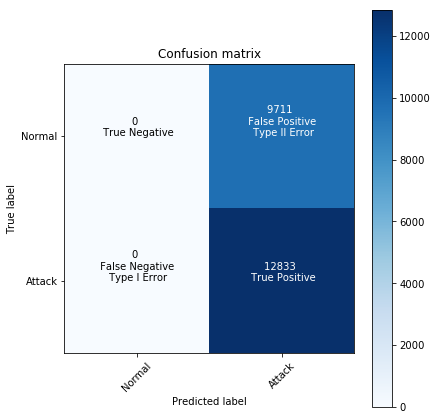

In [31]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [32]:
df_.groupby(by="Actual").Actual.count()

Actual
0.0    2152
1.0    9698
Name: Actual, dtype: int64

In [ ]:
plot(actual_value = df_.loc[:,'Actual'].values.astype(int),
     pred_value = df_.loc[:,'Prediction'].values.astype(int))

In [ ]:
from scipy import stats

def fn(x):
    #print(x)
    return stats.norm.interval(0.95, loc=x.f1_score.mean(), scale=x.f1_score.std())
psg.apply(fn)